# Topic Modeling By Clustering

In [1]:
# %pip install -r ../requirements.txt

In [2]:
import json
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk
import emoji
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

In [3]:
raw_data = pd.read_csv("../data/processed/reddit_submission.csv")
print(raw_data.info())
raw_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6503 entries, 0 to 6502
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   post_id       6503 non-null   object 
 1   subreddit     6503 non-null   object 
 2   created_utc   6503 non-null   float64
 3   title         6503 non-null   object 
 4   selftext      5393 non-null   object 
 5   score         6503 non-null   int64  
 6   num_comments  6503 non-null   int64  
 7   upvote_ratio  6503 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 406.6+ KB
None


,post_id,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio
0,1nkes7e,Anxiety,1.758217e+09,Terrified of my symptoms,So I just got over a nasty cold but the cough ...,1,0,1.0
1,1nkes09,Anxiety,1.758217e+09,Does anyone else here have chronic tinnitus?,This crap is driving me insane.\n\nI’ve been a...,1,0,1.0
2,1njtn2a,Anxiety,1.758154e+09,I can't sleep anymore,"Hey everyone, I've been diagnosed with anxiety...",1,1,1.0
3,1nke28u,Anxiety,1.758215e+09,Losing hope,Ive had health anxiety for 2 minths now. Ever ...,1,0,1.0
4,1nke23t,Anxiety,1.758215e+09,Can someone give me a logical explanation as t...,I'm dizzy all the time and lately my heart fee...,1,2,1.0


### Tokenize posts

In [4]:
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict for replacement
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
stop_words = ENGLISH_STOP_WORDS

# List of punctuation
punc = list(set(string.punctuation))

def casual_tokenizer(text):
    """Tokenizer that preserves contractions and most punctuation."""
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def expandContractions(text, c_re=c_re):
    """Expand contractions in text using c_re."""
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def emojis_to_text(text: str) -> str:
    """
    Replace emojis with descriptive words (e.g., :smiling_face:) and
    add spaces around them so tokenizers split cleanly.
    If the emoji package is unavailable, return the original text.
    """
    if emoji is None:
        return text
    try:
        return emoji.demojize(text, language="en", delimiters=(" ", " "))
    except Exception:
        return text

def process_text(text):
    """
    Preprocess the input text by tokenizing, normalizing, and removing unwanted elements.
    """
    text = emojis_to_text(text)
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

In [5]:
df = raw_data.copy()
df['fulltext'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')
# process the full text
df['processed_full_text'] = df['fulltext'].apply(process_text)
df.head()

,post_id,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio,fulltext,processed_full_text
0,1nkes7e,Anxiety,1.758217e+09,Terrified of my symptoms,So I just got over a nasty cold but the cough ...,1,0,1.0,Terrified of my symptoms So I just got over a ...,"[terrifi, symptom, just, got, nasti, cold, cou..."
1,1nkes09,Anxiety,1.758217e+09,Does anyone else here have chronic tinnitus?,This crap is driving me insane.\n\nI’ve been a...,1,0,1.0,Does anyone else here have chronic tinnitus? T...,"[doe, anyon, els, chronic, tinnitus, crap, dri..."
2,1njtn2a,Anxiety,1.758154e+09,I can't sleep anymore,"Hey everyone, I've been diagnosed with anxiety...",1,1,1.0,"I can't sleep anymore Hey everyone, I've been ...","[sleep, anymor, hey, everyon, diagnos, anxieti..."
3,1nke28u,Anxiety,1.758215e+09,Losing hope,Ive had health anxiety for 2 minths now. Ever ...,1,0,1.0,Losing hope Ive had health anxiety for 2 minth...,"[lose, hope, ive, health, anxieti, minth, sinc..."
4,1nke23t,Anxiety,1.758215e+09,Can someone give me a logical explanation as t...,I'm dizzy all the time and lately my heart fee...,1,2,1.0,Can someone give me a logical explanation as t...,"[someon, logic, explan, whi, feel, way, convin..."


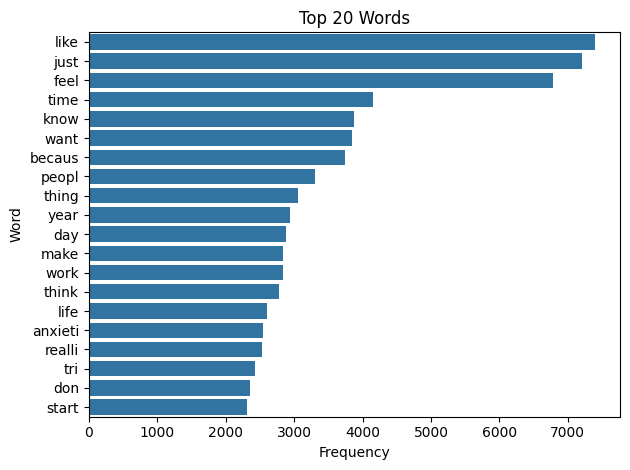

In [6]:
def plot_top20_words():
    words = [w.lower() for row in df['processed_full_text'].dropna() for w in row]
    top = Counter(words).most_common(20)
    words, counts = zip(*top) if top else ([], [])
    sns.barplot(x=list(counts), y=list(words))
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.title('Top 20 Words')
    plt.tight_layout()
    
    plt.show()

plot_top20_words()

We may need to extend the list of stop words to avoid meaningless words such as case, ai, type, use...

In [7]:

texts = df['processed_full_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Run the nmf model
nmf = NMF(
    n_components=10,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0,
    tol=1e-4,
    random_state=42
)

doc_topic = nmf.fit_transform(tfidf)
topic_word = nmf.components_

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
top_words_idx = np.argsort(topic_word, axis=1)[:, ::-1][:, :10]
top_words = [feature_names[idx].tolist() for idx in top_words_idx]
topic_labels = [" ".join(words[:5]) for words in top_words]

top_topic = np.argmax(doc_topic, axis=1)
top_score = doc_topic[np.arange(doc_topic.shape[0]), top_topic]
assignments = pd.DataFrame({
    "topic": top_topic,
    "score": top_score,
    "label": [topic_labels[t] for t in top_topic],
}, index=df.index)


assignments_renamed = assignments.rename(
    columns={"topic": "nmf_topic", "score": "nmf_score", "label": "nmf_label"}
)
df = df.join(assignments_renamed[["nmf_topic", "nmf_score", "nmf_label"]])

df.head()


,post_id,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio,fulltext,processed_full_text,nmf_topic,nmf_score,nmf_label
0,1nkes7e,Anxiety,1.758217e+09,Terrified of my symptoms,So I just got over a nasty cold but the cough ...,1,0,1.0,Terrified of my symptoms So I just got over a ...,"[terrifi, symptom, just, got, nasti, cold, cou...",3,0.037669,anxieti health attack panic health anxieti
1,1nkes09,Anxiety,1.758217e+09,Does anyone else here have chronic tinnitus?,This crap is driving me insane.\n\nI’ve been a...,1,0,1.0,Does anyone else here have chronic tinnitus? T...,"[doe, anyon, els, chronic, tinnitus, crap, dri...",3,0.074016,anxieti health attack panic health anxieti
2,1njtn2a,Anxiety,1.758154e+09,I can't sleep anymore,"Hey everyone, I've been diagnosed with anxiety...",1,1,1.0,"I can't sleep anymore Hey everyone, I've been ...","[sleep, anymor, hey, everyon, diagnos, anxieti...",3,0.060272,anxieti health attack panic health anxieti
3,1nke28u,Anxiety,1.758215e+09,Losing hope,Ive had health anxiety for 2 minths now. Ever ...,1,0,1.0,Losing hope Ive had health anxiety for 2 minth...,"[lose, hope, ive, health, anxieti, minth, sinc...",3,0.069729,anxieti health attack panic health anxieti
4,1nke23t,Anxiety,1.758215e+09,Can someone give me a logical explanation as t...,I'm dizzy all the time and lately my heart fee...,1,2,1.0,Can someone give me a logical explanation as t...,"[someon, logic, explan, whi, feel, way, convin...",5,0.056779,feel like feel like just don


Need to work on NMF model to improve the accuracy of nmf_label.

# Maria Edits (Mixed with Shuting's Update)

### Workflow & Results

**Updated Process**: Tune larger k values → Generate topic labels with NMF → Score anxiety two ways (NRC Emotion, NRC VAD) → Compare outcomes and flag the preferred method.

**Key Results**:
- **Topics (k = 50)**: Determined k = 50, with some metric degradation accepted to maintain a larger topic set for NRC evaluation.
- **NRC Emotion Anxiety** Range 0.07-1.00 (well-distributed).
- **VAD Comparison**: After spot-checking, the NRC Emotion Lexicon remains the more reliable anxiety signal; VAD adds nuance but proved less accurate for this use case.

### 0. Evaluating K Values
**Purpose**: Evaluate a range of larger topic counts (k) so we can balance the desire for finer-grained, unique topics against the inevitable drop in coherence and assignment confidence. The goal is to choose a k that keeps nmf_label informative enough for downstream NRC lexicon analysis while still delivering the richer topic diversity we need.

,k,npmi_coherence,mean_topic_cosine,assignment_purity,iterations
0,20,0.581,0.161,0.620,80
1,30,0.582,0.134,0.538,100
2,40,0.558,0.113,0.485,100
3,50,0.498,0.106,0.426,110
4,60,0.487,0.100,0.416,110
5,70,0.484,0.094,0.383,110
6,80,0.468,0.086,0.383,120


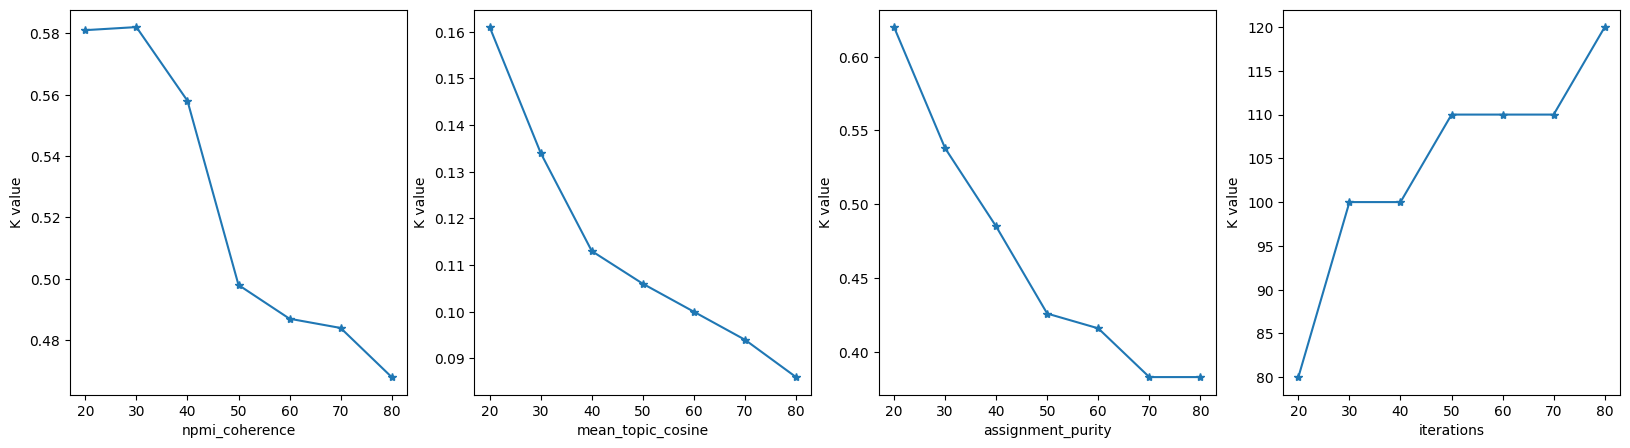

In [8]:
dict_k = {
    'k': [20, 30, 40, 50, 60, 70, 80],
    'npmi_coherence': [0.581, 0.582, 0.558, 0.498, 0.487, 0.484, 0.468],
    'mean_topic_cosine': [0.161, 0.134, 0.113, 0.106, 0.100, 0.094, 0.086],
    'assignment_purity': [0.620, 0.538, 0.485, 0.426, 0.416, 0.383, 00.383],
    'iterations': [80, 100, 100, 110, 110, 110, 120],
}

results_df = pd.DataFrame(dict_k)
display(results_df)

plt.subplots(1,4,figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(results_df['k'], results_df.iloc[:,i+1], marker='*')
    plt.xlabel(results_df.columns[i+1])
    plt.ylabel('K value')

We’ll move forward with **k = 50** topics: 
- It gives us finer-grained clusters than the low-k baselines, yet it holds onto acceptable quality—NPMI coherence and assignment purity dip only modestly compared with k = 30, while mean topic cosine still drops enough to keep the themes well separated. 
- In practice that means we capture useful nuance without fragmenting posts into too many low-confidence micro-topics, striking a balance between interpretability and granularity that fits both the modeling metrics and our review workflows.

### 1. Imports & Configuration

**Purpose**: Initialize required libraries, set reproducible seeds, define final TF-IDF/NMF hyperparameters, and optionally specify the NRC lexicon path for emotion features.
```python

In [9]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.stem import PorterStemmer
import json, joblib, os
from pathlib import Path

__version__ = "2.0.0"
EXPERIMENT_NAME = "reddit_nmf"

CONFIG = {
    "random_state": 0,
    "final_k": 50, # Changed from 8 to 50
    "init": "nndsvda", # Add init method here
    "vectorizer": {
        "ngram_range": (1,2), 
        "min_df": 12,     
        "max_df": 0.4,        
        "max_features": 10000,
        # Remove stop_words from here
    },
    "nmf": {
        "solver": "mu", 
        "beta_loss": "kullback-leibler", 
        "alpha_W": 0.0, 
        "alpha_H": 0.1, 
        "l1_ratio": 0.7,
        "max_iter": 1500, 
        "tol": 1e-4
    }
}

NRC_PATH = Path("../data/raw/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")


In [10]:
def ensure_tokens(x):
    """Coerce item into list[str] with better error handling"""
    # Handle None and NaN cases
    if x is None:
        return []
    
    # Safe check for pandas NA
    try:
        if pd.isna(x):
            return []
    except:
        # If pd.isna() fails, continue with other checks
        pass
    
    # Convert everything to string first, then process
    try:
        if isinstance(x, list):
            # Handle list of tokens
            tokens = [str(t).strip() for t in x if t is not None]
            return [t for t in tokens if t and len(t) > 1]
        else:
            # Convert to string and split
            text = str(x).strip()
            if not text or text.lower() in ['nan', 'none', '']:
                return []
            tokens = text.lower().split()
            return [t for t in tokens if len(t) > 1]
    except:
        return []

### 2. Data Loading & Tokenization

**Purpose**: Load a DataFrame (from memory or `data.csv`), select the text column, and convert each document into a lowercase token list for downstream processing.
```python

In [11]:
if "df" not in globals():
    if os.path.exists("data.csv"):
        df = pd.read_csv("data.csv")
    else:
        raise RuntimeError("No DataFrame `df` in memory and 'data.csv' not found. "
                           "Create `df` with a text column (e.g., 'processed_full_text' or 'text').")

# pick a text column
CANDIDATE_TEXT_COLS = ["processed_full_text", "cleaned_text", "fulltext", "selftext", "text"]
TEXT_COL = next((c for c in CANDIDATE_TEXT_COLS if c in df.columns), None)
if TEXT_COL is None:
    raise RuntimeError(f"Could not find a text column in df. Looked for: {CANDIDATE_TEXT_COLS}")

def ensure_tokens(x):
    """Coerce item into list[str]. Uses whitespace split if a string; otherwise empty list."""
    if isinstance(x, list):  return [str(t) for t in x]
    if isinstance(x, str):   return x.lower().split()
    return []

texts_tokens = [ensure_tokens(v) for v in df[TEXT_COL].fillna("")]


### 3. Helper Functions

**Purpose**: Provide lightweight utilities for topic-model diagnostics and labeling—lift-based top terms, mean inter-topic cosine, assignment purity, NPMI coherence, and concise label generation.
```python

In [12]:
def identity(x): 
    """Identity function for sklearn compatibility"""
    return x

def top_terms_by_lift(H, X, vocab, topn=12):
    """Get top terms by lift score with better numerical stability"""
    tf = np.asarray(X.sum(axis=0)).ravel()
    tf = tf + np.finfo(float).eps  # Better than 1e-12
    
    lift = H / tf[np.newaxis, :]  # More explicit broadcasting
    order = np.argsort(lift, axis=1)[:, ::-1]
    
    return [[vocab[j] for j in row[:topn]] for row in order], order

def mean_topic_cosine(H):
    """Compute mean pairwise cosine similarity between topics"""
    # Add early return for edge cases
    if H.shape[0] <= 1:
        return 0.0
        
    norms = np.linalg.norm(H, axis=1, keepdims=True)
    norms = np.maximum(norms, np.finfo(float).eps)  # Avoid division by zero
    Hn = H / norms
    
    cos = Hn @ Hn.T
    np.fill_diagonal(cos, 0.0)
    
    # Only consider upper triangle to avoid double counting
    mask = np.triu(np.ones_like(cos, dtype=bool), k=1)
    return float(cos[mask].mean())

def assignment_purity(W, thresh=0.40):
    """Calculate assignment purity with validation"""
    if W.size == 0:
        return 0.0, np.array([])
        
    row_sums = W.sum(axis=1, keepdims=True)
    row_sums = np.maximum(row_sums, np.finfo(float).eps)
    P = W / row_sums
    
    purity = float((P.max(axis=1) >= thresh).mean())
    return purity, P

def coherence_npmi(topics, docs, min_co=2, eps=1e-12):  # Increase min_co default
    """
    NPMI coherence with better performance and validation
    """
    if not topics or not docs:
        return float("nan")
        
    N = len(docs)
    if N == 0:
        return float("nan")
    
    # Pre-compute document frequency more efficiently
    doc_sets = [set(d) for d in docs if d]  # Filter empty docs
    
    # Use Counter for efficiency
    word_doc_freq = Counter()
    for doc_set in doc_sets:
        for word in doc_set:
            word_doc_freq[word] += 1
    
    def get_cooccurrence(w1, w2):
        """Count documents containing both words"""
        return sum(1 for doc_set in doc_sets if w1 in doc_set and w2 in doc_set)
    
    all_scores = []
    
    for topic_words in topics:
        if len(topic_words) < 2:
            continue
            
        pairs_scores = []
        for i in range(len(topic_words)):
            for j in range(i + 1, len(topic_words)):  # More efficient pairing
                w1, w2 = topic_words[j], topic_words[i]  # j > i for consistency
                
                cooc = get_cooccurrence(w1, w2)
                if cooc < min_co:
                    continue
                
                p_w1_w2 = cooc / N
                p_w1 = word_doc_freq.get(w1, 0) / N
                p_w2 = word_doc_freq.get(w2, 0) / N
                
                if p_w1 <= eps or p_w2 <= eps or p_w1_w2 <= eps:
                    continue
                
                pmi = np.log(p_w1_w2 / (p_w1 * p_w2))
                npmi = pmi / (-np.log(p_w1_w2))
                
                if not np.isfinite(npmi):
                    continue
                    
                pairs_scores.append(npmi)
        
        if pairs_scores:
            all_scores.append(np.mean(pairs_scores))
    
    return float(np.mean(all_scores)) if all_scores else float("nan")

def make_label(words, n=3, max_len=28):
    """Create topic label with better handling"""
    if not words:
        return "empty_topic"
    
    # Filter out very short or non-meaningful words for labels
    meaningful_words = [w for w in words if len(w) > 2]
    if not meaningful_words:
        meaningful_words = words
    
    label = " / ".join(meaningful_words[:n])
    return label[:max_len] + "..." if len(label) > max_len else label

### 4. Baseline Stoplist Construction

**Purpose**: Fit a quick TF-IDF+NMF baseline to auto-identify ubiquitous, low-salience terms (via lift and topic overlap) and merge them with domain stopwords to form a unified stoplist (`STOP_ALL`).
```python

In [13]:
# More systematic hyperparameter setup for initial fit
INITIAL_PARAMS = {
    "ngram_range": (1,2), 
    "min_df": 10, 
    "max_df": 0.6, 
    "max_features": 20000,
    "sublinear_tf": True, 
    "norm": "l2"
}

print("Running initial fit for automatic stopword detection...")
vec0 = TfidfVectorizer(
    tokenizer=identity, 
    preprocessor=identity, 
    token_pattern=None, 
    lowercase=False,
    stop_words=None,
    **INITIAL_PARAMS
)

X0 = vec0.fit_transform(texts_tokens)
voc0 = np.array(vec0.get_feature_names_out())

print(f"Initial vocabulary size: {len(voc0):,}")
print(f"Document-term matrix shape: {X0.shape}")

nmf0 = NMF(
    n_components=CONFIG["final_k"], 
    init= CONFIG["init"],
    solver="mu", 
    beta_loss="kullback-leibler",
    alpha_W=0.0, 
    alpha_H=0.0, 
    l1_ratio=0.0,
    max_iter=800, 
    tol=1e-4, 
    random_state=CONFIG["random_state"]
).fit(X0)

top0, ord0 = top_terms_by_lift(nmf0.components_, X0, voc0, topn=12)

# More sophisticated stopword detection
word_counts = Counter(w for topic_words in top0 for w in topic_words)
auto_threshold = max(2, CONFIG["final_k"] // 2)  # At least 2, but scale with K

AUTO_STOP = {w for w, count in word_counts.items() if count >= auto_threshold}

# Enhanced domain stopwords - could be loaded from config
DOMAIN_STOP = {
    # Platform terms
    "gpt", "chatgpt", "codex", "claude", "openai", "anthropic", "llm", "ai",
    # Generic terms  
    "work", "time", "user", "people", "person", "post", "new", "need", "way", 
    "model", "code", "someth", "peopl", "whi", "becaus", "tri", "actual",
    "know", "think", "want", "make", "say", "said", "tell", "come", "look",
    "use", "thing", "year", "day", "month", "week", "get", "got", "go", "went",
    "see", "seen", "feel", "felt", "help", "try", "start", "end", "give", "take",
    "find", "found", "seem", "believe", "understand", "mean", "happen", "turn",
    "keep", "put", "call", "ask", "let", "leave", "move", "show", "bring"
    # Reddit-specific
    "like", "just", "realli", "didn", "ll", "weren", "ve", "don", "im",
    "anyon", "doe", "similar", "situat", "kind", "like",  # From Topic 8
    # Add based on domain
    "reddit", "thread", "comment", "subreddit", "upvote"
}

STOP_ALL = AUTO_STOP | DOMAIN_STOP

print(f"Stopwords - Auto: {len(AUTO_STOP)}, Domain: {len(DOMAIN_STOP)}, Total: {len(STOP_ALL)}")
print(f"Most frequent cross-topic terms: {dict(word_counts.most_common(10))}")

Running initial fit for automatic stopword detection...
Initial vocabulary size: 7,080
Document-term matrix shape: (6503, 7080)
Stopwords - Auto: 0, Domain: 90, Total: 90
Most frequent cross-topic terms: {'use reddit': 1, 'know actual': 1, 'mayb year': 1, 'stori short': 1, 'read far': 1, 'long stori': 1, 'ungrat': 1, 'anoth thing': 1, 'main reason': 1, 'make sure': 1}


In [14]:
print("Fitting final model...")

# Use config parameters
vec_final = TfidfVectorizer(
    tokenizer=identity, 
    preprocessor=identity, 
    token_pattern=None, 
    lowercase=False,
    stop_words=list(STOP_ALL),  #custom stopwords
    **CONFIG["vectorizer"],
    sublinear_tf=True, 
    norm="l2"
)

Xf = vec_final.fit_transform(texts_tokens)
vocab_f = np.array(vec_final.get_feature_names_out())

print(f"Final vocabulary size: {len(vocab_f):,} (reduced from {len(voc0):,})")
print(f"Final matrix density: {Xf.nnz / (Xf.shape[0] * Xf.shape[1]):.4f}")

# Add timing and convergence tracking
import time
start_time = time.time()

nmf_final = NMF(
    n_components=CONFIG["final_k"], 
    init="nndsvd",
    random_state=CONFIG["random_state"],
    **CONFIG["nmf"]
).fit(Xf)

fit_time = time.time() - start_time
print(f"NMF fitting took {fit_time:.1f} seconds")
print(f"Converged in {nmf_final.n_iter_} iterations")

# Enhanced topic display
top_terms_f, order_f = top_terms_by_lift(nmf_final.components_, Xf, vocab_f, topn=12)

print("\n=== Topics by Lift Score ===")
for i, words in enumerate(top_terms_f):
    # Show topic strength
    topic_strength = nmf_final.components_[i].sum()
    print(f"Topic {i} (strength: {topic_strength:.3f}): {', '.join(words)}")

# Calculate and display metrics
print("\n=== Calculating metrics ===")
mean_cos = mean_topic_cosine(nmf_final.components_)
Wf = nmf_final.transform(Xf)
purity, P = assignment_purity(Wf, thresh=0.40)

# Time the coherence calculation (it's often the slowest)
coherence_start = time.time()
npmi = coherence_npmi([ws[:10] for ws in top_terms_f], texts_tokens, min_co=2)
coherence_time = time.time() - coherence_start

print(f"\n=== Final Metrics ===")
print(f"NPMI coherence: {npmi:.3f} (computed in {coherence_time:.1f}s)")
print(f"Mean topic cosine: {mean_cos:.3f}")
print(f"Assignment purity: {purity:.3f}")

# Add model persistence
model_artifacts = {
    'vectorizer': vec_final,
    'nmf_model': nmf_final,
    'topic_terms': top_terms_f,
    'config': CONFIG,
    'metrics': {'npmi': npmi, 'mean_cosine': mean_cos, 'purity': purity}
}

Fitting final model...


/Users/shutinghe/.pyenv/versions/garden_env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


Final vocabulary size: 3,791 (reduced from 7,080)
Final matrix density: 0.0112


/Users/shutinghe/.pyenv/versions/garden_env/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1581: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


NMF fitting took 16.5 seconds
Converged in 100 iterations

=== Topics by Lift Score ===
Topic 0 (strength: 0.081): cross line, hung, close friend, fast forward, confront, stop talk, couldn, did wrong, apolog, veri close, rest life, honest thought
Topic 1 (strength: 0.007): imag, strive, generat, art, path, extern, sh, concret, judgment, courag, greatest, oppos
Topic 2 (strength: 0.034): bad panic, ani medic, anxieti veri, anxieti past, ativan, doctor prescrib, panic disord, clonazepam, anxieti medic, anxieti life, bad anxieti, xanax
Topic 3 (strength: 0.026): hedg, portfolio, donald trump, donald, revenu, trump, presid, polici, administr, firm, institut, accord fool
Topic 4 (strength: 0.007): pleas share, pleas someon, issu mega, meta, pleas topic, mega pleas, mega, topic, famili issu, religion, parent famili, mod
Topic 5 (strength: 0.033): littl brother, mom dad, older brother, mom told, pregnant, emot abus, grandpar, parent alway, live parent, famili live, left alon, funer
Topic 6 (s

### 5. Labels & Document Assignments

**Purpose**: Create human-readable topic labels and attach per-document topic index, confidence, and label; then summarize topic prevalence.
```python

In [15]:
# Create more informative labels
labels_f = [make_label(ws, n=3, max_len=35) for ws in top_terms_f] 

# Add confidence statistics
df["nmf_topic"] = P.argmax(axis=1)
df["nmf_conf"] = P.max(axis=1)
df["nmf_label"] = df["nmf_topic"].map(dict(enumerate(labels_f)))

# topic analysis
topic_stats = df.groupby('nmf_topic').agg({
    'nmf_conf': ['count', 'mean', 'std'],
    TEXT_COL: lambda x: np.mean([len(ensure_tokens(t)) for t in x])  # avg length
}).round(3)

topic_stats.columns = ['doc_count', 'avg_confidence', 'conf_std', 'avg_doc_length']
topic_stats['topic_label'] = [labels_f[i] for i in topic_stats.index]

topic_stats = topic_stats.reset_index() # reset index for merging

print("\n=== Topic Statistics ===")
display(topic_stats.sort_values('doc_count', ascending=False))

# Check for unassigned documents (low confidence)
low_conf_docs = (df['nmf_conf'] < 0.3).sum()
if low_conf_docs > 0:
    print(f"\nWarning: {low_conf_docs:,} documents ({low_conf_docs/len(df):.1%}) have low confidence (<0.3)")


=== Topic Statistics ===


,nmf_topic,doc_count,avg_confidence,conf_std,avg_doc_length,topic_label
1,1,206,0.719,0.244,9.403,imag / strive / generat
23,23,195,0.574,0.222,30.215,china / currenc / tariff
13,13,185,0.349,0.143,89.973,sleep better / sleep hour / hour sl...
24,24,184,0.451,0.190,78.451,anxieti heart / chest pain / heart ...
48,48,169,0.370,0.186,108.740,men / date app / intim
10,10,167,0.504,0.219,55.593,ice cream / sauc / spice
38,38,158,0.392,0.196,103.886,blog / filter / github
6,6,153,0.364,0.169,72.810,deal health / mental health / strug...
5,5,152,0.251,0.104,186.316,littl brother / mom dad / older bro...
44,44,152,0.418,0.203,77.303,movi / ladder / friend alway


In [16]:
# Merge topic stats to gain topic labels, which will be used for NRC analysis
df = df.merge(topic_stats[['nmf_topic', 'topic_label']], left_on='nmf_topic', right_index=True, how='left')
df.drop(columns=['nmf_topic_x','nmf_topic_y' ], inplace=True)  # drop old label if exists
df.head(2)

,nmf_topic,post_id,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio,fulltext,processed_full_text,nmf_score,nmf_label,nmf_conf,topic_label
0,30,1nkes7e,Anxiety,1.758217e+09,Terrified of my symptoms,So I just got over a nasty cold but the cough ...,1,0,1.0,Terrified of my symptoms So I just got over a ...,"[terrifi, symptom, just, got, nasti, cold, cou...",0.037669,tumor / english languag / stop worr...,0.211699,tumor / english languag / stop worr...
1,24,1nkes09,Anxiety,1.758217e+09,Does anyone else here have chronic tinnitus?,This crap is driving me insane.\n\nI’ve been a...,1,0,1.0,Does anyone else here have chronic tinnitus? T...,"[doe, anyon, els, chronic, tinnitus, crap, dri...",0.074016,anxieti heart / chest pain / heart ...,0.450301,anxieti heart / chest pain / heart ...


### 6. NRC-Based Anxiety Scoring (0–1)

**Purpose**: Load the NRC Emotion Lexicon, build a stem-aware emotion map, and compute a length-robust anxiety score per document using windowed negation and intensity cues.
```python

In [17]:
from nltk.stem import PorterStemmer
import warnings

def load_nrc_lexicon(path):
    """Load NRC lexicon with better error handling and validation"""
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"NRC lexicon not found at {path}")
    
    try:
        # Try long format first
        nrc = pd.read_csv(path, sep=r"[\t,]", engine="python", header=None,
                         names=["word", "emotion", "association"])
        
        if {"word", "emotion", "association"}.issubset(nrc.columns):
            nrc = nrc[nrc["association"].astype(int) == 1][["word", "emotion"]]
            nrc["word"] = nrc["word"].str.lower().str.strip()
            print(f"Loaded NRC lexicon: {len(nrc)} word-emotion pairs")
            return nrc
            
    except Exception as e:
        print(f"Long format failed: {e}")
        
    # Fallback to wide format
    try:
        nrc = pd.read_csv(path)
        if "word" not in nrc.columns:
            nrc = nrc.rename(columns={nrc.columns[0]: "word"})
        nrc = nrc.set_index("word")
        
        EXPECTED_EMOTIONS = {"anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"}
        found_emotions = set(nrc.columns) & EXPECTED_EMOTIONS
        
        if not found_emotions:
            raise ValueError(f"No expected emotions found in columns: {list(nrc.columns)}")
        
        long_rows = []
        for emo in found_emotions:
            words = nrc.index[nrc[emo] == 1]
            long_rows.extend([(w.lower().strip(), emo) for w in words])
        
        result = pd.DataFrame(long_rows, columns=["word", "emotion"])
        print(f"Loaded NRC lexicon (wide format): {len(result)} word-emotion pairs")
        return result
        
    except Exception as e:
        raise RuntimeError(f"Could not load NRC lexicon from {path}: {e}")

# Load and process lexicon
nrc_long = load_nrc_lexicon(NRC_PATH)

# Build stem-aware lexicon with caching
ps = PorterStemmer()

print("Building stem-aware emotion lexicon...")
nrc_long["stem"] = nrc_long["word"].apply(ps.stem)

# Group emotions by stem
LEX_STEM = nrc_long.groupby("stem")["emotion"].apply(set).to_dict()
print(f"Stem lexicon size: {len(LEX_STEM)} stems")

# Enhanced modifier sets (could be loaded from config)
NEGATORS = {"not", "no", "never", "without", "hardly", "barely", "neither", "none"}
INTENSIFY = {"very", "extremely", "super", "really", "totally", "absolutely", "completely"}
DIMINISH = {"slightly", "somewhat", "kinda", "barely", "little", "bit"}

# Rebalanced emotion weights (consider making these configurable)
EMO_WEIGHTS = {
    "fear": 1.0, 
    "anger": 0.8,      # Increased
    "sadness": 0.7,    # Increased  
    "disgust": 0.4,    # Increased
    "anticipation": 0.2,
    "surprise": 0.1,
    "trust": -0.4,     # More negative
    "joy": -0.8        # More negative
}

def compute_anxiety_score(tokens, window_size=3):
    """
    Compute anxiety score with improved context handling
    """
    if not isinstance(tokens, list):
        tokens = ensure_tokens(tokens)
    
    if len(tokens) == 0:
        return 0.0
    
    total_score = 0.0
    emotion_hits = 0
    
    for i, token in enumerate(tokens):
        stem = ps.stem(token.lower())
        emotions = LEX_STEM.get(stem, set())
        
        if not emotions:
            continue
        
        # Look at context window
        start_idx = max(0, i - window_size)
        context = tokens[start_idx:i]
        context_lower = [w.lower() for w in context]
        
        # Calculate modifiers
        modifier = 1.0
        
        if any(neg in context_lower for neg in NEGATORS):
            modifier *= -0.6  # Made less extreme
        if any(intens in context_lower for intens in INTENSIFY):
            modifier *= 1.5   # Slightly increased
        if any(dim in context_lower for dim in DIMINISH):
            modifier *= 0.6   # Made less extreme
        
        # Sum emotion contributions
        emotion_score = sum(EMO_WEIGHTS.get(emotion, 0.0) for emotion in emotions)
        total_score += modifier * emotion_score
        emotion_hits += 1
    
    if emotion_hits == 0:
        return 0.0
    
    # Normalize by square root to dampen very high scores
    return total_score / (emotion_hits ** 0.5)

# Rename for clarity
anxiety_raw = compute_anxiety_score

Loaded NRC lexicon: 13872 word-emotion pairs
Building stem-aware emotion lexicon...
Stem lexicon size: 5330 stems


### 8. Save Artifacts for Reuse

**Purpose**: Persist the trained vectorizer, NMF model, topic labels, and annotated dataset to disk for downstream analysis and reproducible pipelines.
```python

In [18]:
# =========================
# 7) Save artifacts for reuse
# # =========================
# joblib.dump(vec_final, "vec_final.joblib")
# joblib.dump(nmf_final, "nmf_final.joblib")
# with open("topic_labels.json", "w") as f:
#     json.dump(labels_f, f, indent=2)
# df.to_csv("posts_with_topics_and_anxiety.csv", index=False)

# print("\nSaved: vec_final.joblib, nmf_final.joblib, topic_labels.json, posts_with_topics_and_anxiety.csv")

### Word Cloud Visualization
**Purpose**: Create visual word clouds to explore vocabulary patterns across all text, anxiety levels, and topics.


In [19]:
def _pick_tokens_df(df):
    # choose a text column if tokens list is missing
    for c in ["processed_full_text","cleaned_text","fulltext","selftext","text","title"]:
        if c in df.columns: return c
    raise RuntimeError("No suitable text column found.")


In [29]:
# # 1) Get tokens
# try:
#     tokens_list = texts_tokens
# except NameError:
#     # Build tokens from a text column if needed
#     CANDIDATE_TEXT_COLS = ["processed_full_text","cleaned_text","fulltext","selftext","text","title"]
#     TEXT_COL = next((c for c in CANDIDATE_TEXT_COLS if c in df.columns), None)
#     if TEXT_COL is None:
#         raise RuntimeError(f"Need a text column in df. Looked for: {CANDIDATE_TEXT_COLS}")

# --- UPDATED ---
# 1) Get topic-label tokens
LABEL_COL = "topic_label" if "topic_label" in df.columns else "nmf_label"
if LABEL_COL not in df.columns:
    raise RuntimeError("Need either 'topic_label' or 'nmf_label' on df before scoring.")

label_tokens = [
    ensure_tokens(label.replace("/", " "))
    for label in df[LABEL_COL].fillna("")
]

# 2) Compute anxiety_raw via NRC function if needed
if "anxiety_raw" not in df.columns:
    try:
        _ = anxiety_raw  # ensure function exists
    except NameError:
        raise RuntimeError("Run the NRC scoring cell that defines `anxiety_raw` (and lexicon) first.")
    # df["anxiety_raw"] = [anxiety_raw(toks) for toks in tokens_list]
    df["anxiety_raw"] = [anxiety_raw(tokens) for tokens in label_tokens] # update to use topic label tokens

# 3) Robust 0–1 scaling to create anxiety_score
if "anxiety_score" not in df.columns:
    med = float(df["anxiety_raw"].median())
    mad = float((df["anxiety_raw"] - med).abs().median()) or 1e-6
    z   = (df["anxiety_raw"] - med) / (1.4826 * mad)
    df["anxiety_score"] = 1.0 / (1.0 + np.exp(-z))

print(df["anxiety_score"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]))

# # 4) Build a safe list of columns to display (only keep ones that exist)
# text_cols = [c for c in ["title","selftext","fulltext","text","processed_full_text","cleaned_text"] if c in df.columns]
# meta_cols = [c for c in ["nmf_label","nmf_conf","nmf_topic"] if c in df.columns]
# cols_show = [c for c in (text_cols[:2] + meta_cols + ["anxiety_score"]) if c in df.columns]

# # 5) Show top/bottom posts
# print("\nTop 10 highest anxiety:")
# display(df.sort_values("anxiety_score", ascending=False).head(10)[cols_show])

# print("\nTop 10 lowest anxiety:")
# display(df.sort_values("anxiety_score", ascending=True).head(10)[cols_show])

# 6) Per-topic table if topics exist
# if "nmf_label" in df.columns:
#     topic_table = (df.groupby("nmf_label")["anxiety_score"]
#                      .agg(count="count", mean="mean", median="median")
#                      .sort_values("mean", ascending=False))
#     display(topic_table.head(20))
# else:
#     print("\nNo 'nmf_label' column found.")

# ---- UPDATED ---
group_cols = [c for c in ["nmf_topic", "nmf_label"] if c in df.columns]
topic_scores = (
    df.groupby(group_cols, dropna=False)["anxiety_score"]
      .mean()
      .reset_index()
      .rename(columns={"anxiety_score": "mean_anxiety_score"})
)

print("\nTop 10 topics with highest anxiety:")
display(topic_scores.sort_values("mean_anxiety_score", ascending=False).head(10))

print("\nTop 10 topics with lowest anxiety:")
display(topic_scores.sort_values("mean_anxiety_score", ascending=True).head(10))


# if LABEL_COL in df.columns:
#     topic_table = (df.groupby(LABEL_COL)["anxiety_score"]
#                      .agg(count="count", mean="mean", median="median")
#                      .sort_values("mean", ascending=False))
#     print(f"\nAnxiety by {LABEL_COL}:")
#     display(topic_table.head(20))
    

count    6503.000000
mean        0.578293
std         0.267306
min         0.073699
5%          0.116760
25%         0.403858
50%         0.500000
75%         0.843727
95%         0.998673
max         0.999401
Name: anxiety_score, dtype: float64

Top 10 topics with highest anxiety:


,nmf_topic,nmf_label,mean_anxiety_score
31,31,string / fear death / lose mind,0.999401
24,24,anxieti heart / chest pain / heart ...,0.998742
2,2,bad panic / ani medic / anxieti ver...,0.998052
9,9,fed cut / fed rate / feder reserv,0.994817
19,19,... / horrif / wow,0.992535
26,26,lay bed / depriv / couldn sleep,0.992535
36,36,weight gain / lose weight / watch t...,0.985557
47,47,hyundai / georgia / raid,0.960978
33,33,bike / gun / step step,0.954140
32,32,els notic / case scenario / podcast,0.946170



Top 10 topics with lowest anxiety:


,nmf_topic,nmf_label,mean_anxiety_score
39,39,good good / stay away / lyric,0.073699
6,6,deal health / mental health / strug...,0.080627
49,49,pdf / approv / conscious,0.116760
44,44,movi / ladder / friend alway,0.116760
45,45,esteem / self esteem / crowd,0.232840
27,27,everyon love / ani suggest / advic ...,0.274175
11,11,love talk / friend sinc / fall love,0.336553
5,5,littl brother / mom dad / older bro...,0.337492
41,41,alway good / chang mind / hope some...,0.337492
10,10,ice cream / sauc / spice,0.355220


Creating word cloud for all processed text...


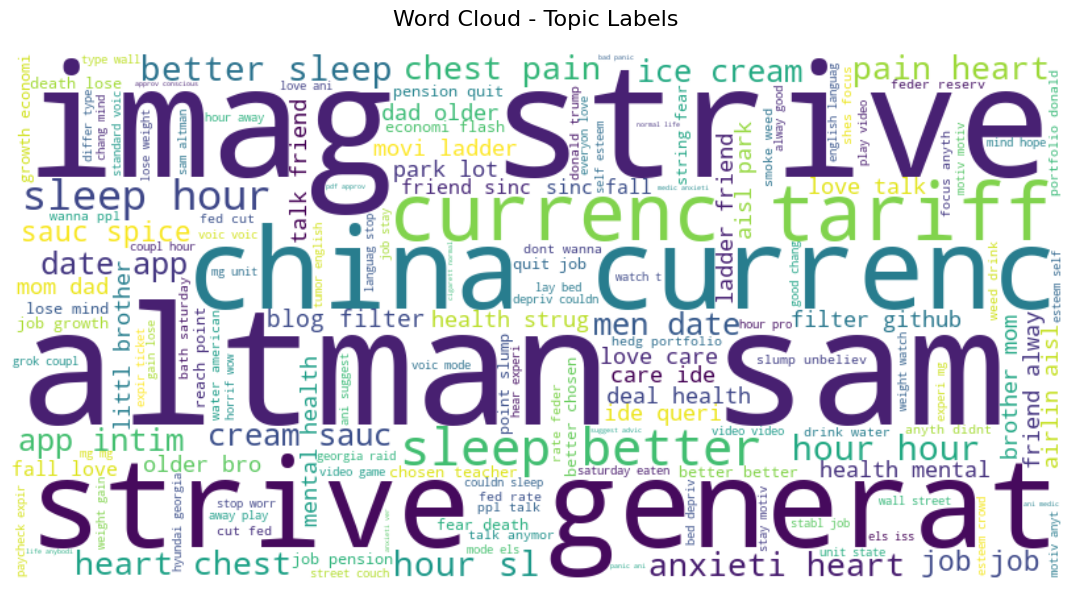

In [31]:
# Word Cloud Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Install wordcloud if not already installed
try:
    from wordcloud import WordCloud
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud

# Create word cloud from processed text
def create_word_cloud(texts, title="Word Cloud", max_words=100, width=800, height=400):
    """Create a word cloud from a list of tokenized texts"""
    # Flatten all tokens into a single string
    all_tokens = []
    for text in texts:
        if isinstance(text, list):
            all_tokens.extend(text)
        elif isinstance(text, str):
            all_tokens.extend(text.split())
    
    # Join tokens with spaces for wordcloud
    text_string = ' '.join(all_tokens)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=width, 
        height=height, 
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate(text_string)
    
    # Display
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return wordcloud

# Create word cloud for all processed text
print("Creating word cloud for all processed text...")
# wordcloud_all = create_word_cloud(
#     df['processed_full_text'].dropna(), 
#     title="Word Cloud - All Processed Text",
#     max_words=150
# )

# --- UPDATED (Using topic labels) ---
wordcloud_all = create_word_cloud(
    df[LABEL_COL].dropna(), 
    title="Word Cloud - Topic Labels",
    max_words=150
)



In [36]:
# Word clouds by anxiety level and topic
# if 'anxiety_score' in df.columns:
#     # High anxiety posts (top 25%)
#     high_anxiety_threshold = df['anxiety_score'].quantile(0.75)
#     high_anxiety_posts = df[df['anxiety_score'] >= high_anxiety_threshold][LABEL_COL].dropna() # changed processed_full_text to topic labels
    
#     # Low anxiety posts (bottom 25%)
#     low_anxiety_threshold = df['anxiety_score'].quantile(0.25)
#     low_anxiety_posts = df[df['anxiety_score'] <= low_anxiety_threshold][LABEL_COL].dropna() # changed processed_full_text to topic labels
    
#     print(f"High anxiety posts: {len(high_anxiety_posts)}")
#     print(f"Low anxiety posts: {len(low_anxiety_posts)}")
    
#     # Create side-by-side comparison
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
#     # High anxiety word cloud
#     if len(high_anxiety_posts) > 0:
#         high_tokens = []
#         for text in high_anxiety_posts:
#             if isinstance(text, list):
#                 high_tokens.extend(text)
#         high_text = ' '.join(high_tokens)
        
#         wordcloud_high = WordCloud(
#             width=400, height=300, background_color='white',
#             max_words=100, colormap='Reds', relative_scaling=0.5,
#             random_state=42
#         ).generate(high_text)
        
#         ax1.imshow(wordcloud_high, interpolation='bilinear')
#         ax1.set_title('High Anxiety Posts (Top 25%)', fontsize=14, pad=20)
#         ax1.axis('off')
    
#     # Low anxiety word cloud
#     if len(low_anxiety_posts) > 0:
#         low_tokens = []
#         for text in low_anxiety_posts:
#             if isinstance(text, list):
#                 low_tokens.extend(text)
#         low_text = ' '.join(low_tokens)
        
#         wordcloud_low = WordCloud(
#             width=400, height=300, background_color='white',
#             max_words=100, colormap='Blues', relative_scaling=0.5,
#             random_state=42
#         ).generate(low_text)
        
#         ax2.imshow(wordcloud_low, interpolation='bilinear')
#         ax2.set_title('Low Anxiety Posts (Bottom 25%)', fontsize=14, pad=20)
#         ax2.axis('off')
    
#     plt.tight_layout()
#     plt.show()

# # Word clouds by topic (if topics exist)
# if 'nmf_label' in df.columns:
#     print("\n" + "="*50)
#     print("Word clouds by topic:")
#     print("="*50)
    
#     # Get top 3 topics by count
#     top_topics = df['nmf_label'].value_counts().head(3)
    
#     for i, (topic, count) in enumerate(top_topics.items()):
#         topic_posts = df[df['nmf_label'] == topic]['processed_full_text'].dropna()
        
#         if len(topic_posts) > 0:
#             topic_tokens = []
#             for text in topic_posts:
#                 if isinstance(text, list):
#                     topic_tokens.extend(text)
#             topic_text = ' '.join(topic_tokens)
            
#             plt.figure(figsize=(10, 5))
#             wordcloud_topic = WordCloud(
#                 width=800, height=400, background_color='white',
#                 max_words=80, colormap='viridis', relative_scaling=0.5,
#                 random_state=42
#             ).generate(topic_text)
            
#             plt.imshow(wordcloud_topic, interpolation='bilinear')
#             plt.axis('off')
#             plt.title(f'Topic: {topic}\n({count} posts)', fontsize=14, pad=20)
#             plt.tight_layout()
#             plt.show()

High anxiety posts: 1659
Low anxiety posts: 1640


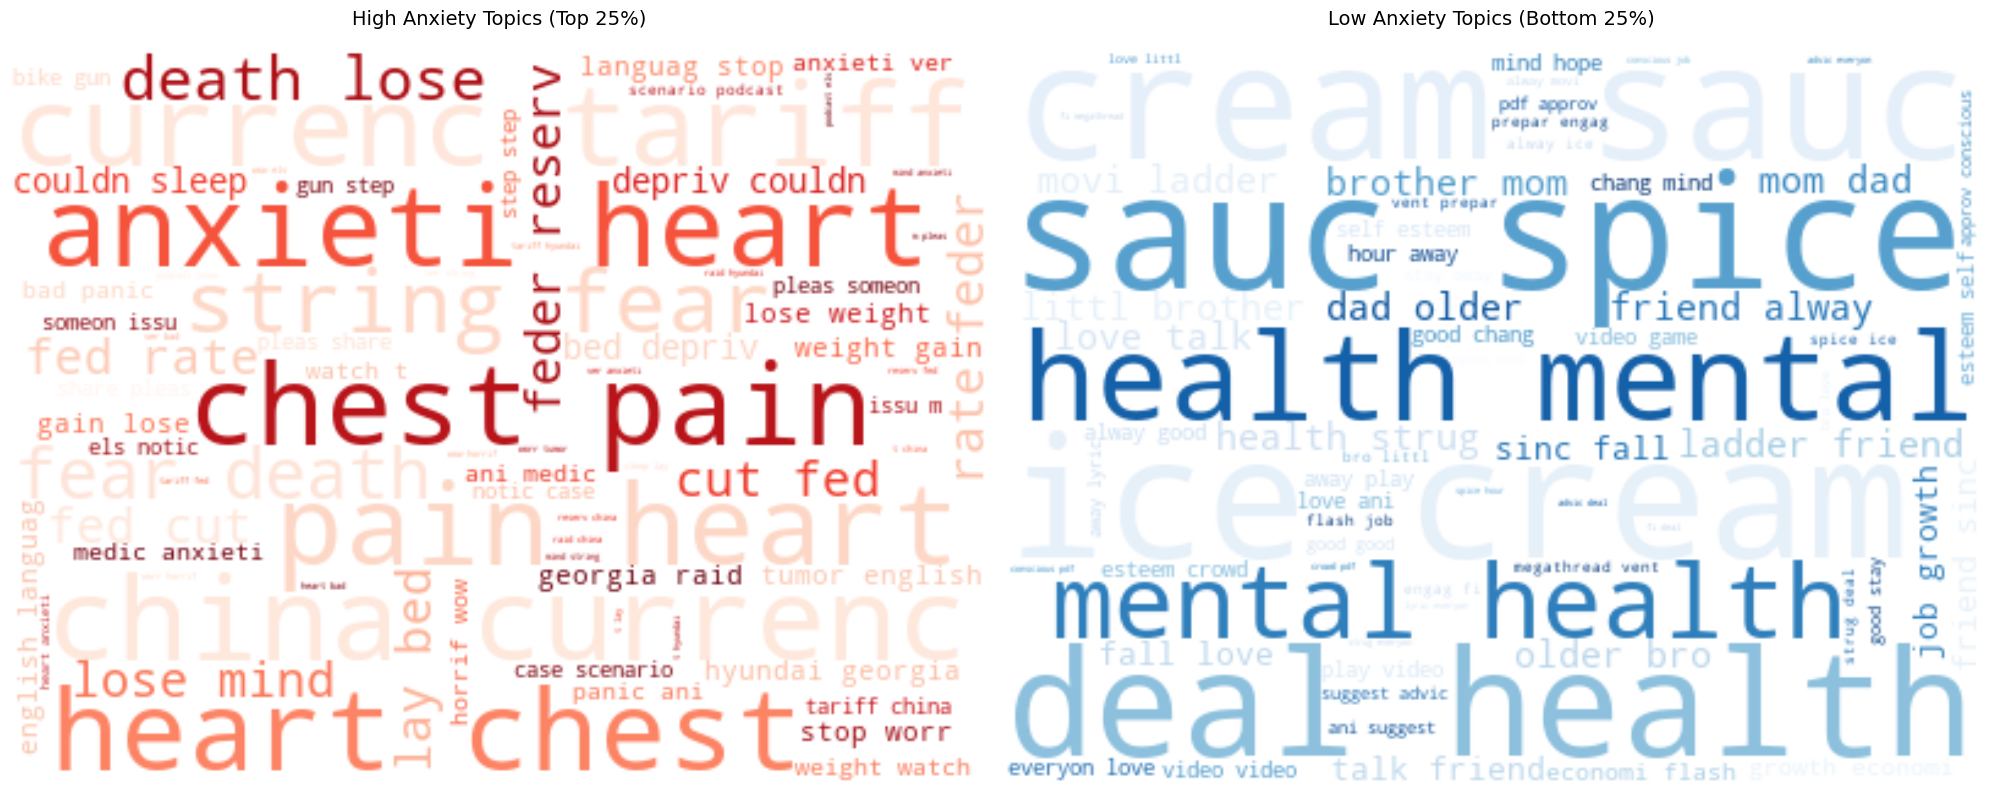

In [37]:
# --- UPDATED (Using topic labels) ---
LABEL_COL = "topic_label" if "topic_label" in df.columns else "nmf_label"

def label_to_tokens(series):
    """Convert label strings into token lists for word-cloud rendering."""
    return series.fillna("").apply(lambda s: ensure_tokens(s.replace("/", " ")))

if "anxiety_score" in df.columns:
    # High anxiety posts (top 25%)
    high_anxiety_threshold = df["anxiety_score"].quantile(0.75)
    high_labels = label_to_tokens(df.loc[df["anxiety_score"] >= high_anxiety_threshold, LABEL_COL])

    # Low anxiety posts (bottom 25%)
    low_anxiety_threshold = df["anxiety_score"].quantile(0.25)
    low_labels = label_to_tokens(df.loc[df["anxiety_score"] <= low_anxiety_threshold, LABEL_COL])

    print(f"High anxiety posts: {len(high_labels)}")
    print(f"Low anxiety posts: {len(low_labels)}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    if len(high_labels) > 0:
        high_text = " ".join(token for tokens in high_labels for token in tokens)
        wordcloud_high = WordCloud(
            width=400, height=300, background_color="white",
            max_words=100, colormap="Reds", relative_scaling=0.5,
            random_state=42
        ).generate(high_text)

        ax1.imshow(wordcloud_high, interpolation="bilinear")
        ax1.set_title("High Anxiety Topics (Top 25%)", fontsize=14, pad=20)
        ax1.axis("off")

    if len(low_labels) > 0:
        low_text = " ".join(token for tokens in low_labels for token in tokens)
        wordcloud_low = WordCloud(
            width=400, height=300, background_color="white",
            max_words=100, colormap="Blues", relative_scaling=0.5,
            random_state=42
        ).generate(low_text)

        ax2.imshow(wordcloud_low, interpolation="bilinear")
        ax2.set_title("Low Anxiety Topics (Bottom 25%)", fontsize=14, pad=20)
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

### NRC VAD Lexicon Exploration
**Purpose**: Estimate topic-level anxiety scores by applying the NRC VAD Lexicon to the topic labels generated by our NMF model.\
\
**Lexicon Background** The NRC VAD Lexicon assigns every word three continuous affective ratings—Valence (pleasant ↔ unpleasant), Arousal (calm ↔ excited), and Dominance (in control ↔ submissive). Unlike the binary NRC Emotion Lexicon, it captures graded intensity and direction on these axes.
\
**Mehrabian & Russell's PAD framework (1974) (1974)** positions anxiety in the unpleasant (low valence), highly aroused, and low-control (low dominance) region of affective space. Later work (e.g., Russell 1980; Bradley & Lang 1994) corroborates that profile. \
\
Because there is no off-the-shelf weighting scheme, we define simple cut points—0.165 (midpoint of 0–0.33) and 0.825 (midpoint of 0.66–0.99)—to serve as low/high anchors. To align with the PAD description, we invert the pleasantness and dominance signals so that words with low valence or low dominance raise the score:\
\
$anxiety\ score ≈ 0.165 * valence  +  0.825 * arousal  +  0.165 * dominance$

This keeps arousal positive (higher arousal → higher anxiety) while flipping valence and dominance so that more negative or disempowered language increases the final score.


In [61]:
# --- 1. Load and stem the NRC VAD lexicon ---
VAD_PATH = Path("../data/raw/NRC_EmoLex_NRC-VAD-Lexicon.txt")

rows = []
with VAD_PATH.open("r", encoding="utf-8") as f:
    for line_no, raw in enumerate(f, start=1):
        line = raw.strip()
        if not line or line.startswith("#"):
            continue

        parts = re.split(r"\t+", line)
        if len(parts) != 4:
            parts = re.split(r"\s+", line)

        if len(parts) != 4:
            warnings.warn(
                f"Skipping malformed line {line_no}: {raw.rstrip()[:80]}",
                RuntimeWarning,
            )
            continue

        rows.append(parts)

vad_raw = (
    pd.DataFrame(rows, columns=["word", "valence", "arousal", "dominance"])
    .assign(
        word=lambda df_: df_["word"].str.lower().str.strip(),
        valence=lambda df_: pd.to_numeric(df_["valence"], errors="coerce"),
        arousal=lambda df_: pd.to_numeric(df_["arousal"], errors="coerce"),
        dominance=lambda df_: pd.to_numeric(df_["dominance"], errors="coerce"),
    )
    .dropna()
    .drop_duplicates("word")
)

vad_raw["stem"] = vad_raw["word"].apply(ps.stem)

# collapse duplicates by stem (simple mean works well enough here)
vad_stem = (
    vad_raw.groupby("stem")[["valence", "arousal", "dominance"]]
    .mean()
    .rename_axis("stem")
)

# --- 2. Prepare topic-label tokens (still stemmed) ---
LABEL_COL = "topic_label" if "topic_label" in df.columns else "nmf_label"
if LABEL_COL not in df.columns:
    raise RuntimeError("Need topic labels before computing VAD anxiety scores.")

def label_to_tokens(series):
    return series.fillna("").apply(lambda s: ensure_tokens(s.replace("/", " ")))

label_tokens = label_to_tokens(df[LABEL_COL])

# --- 3. Apply the anxiety formula with stem lookups ---
VALENCE_WEIGHT = 0.165
AROUSAL_WEIGHT = 0.825
DOMINANCE_WEIGHT = 0.165

def vad_anxiety_for_tokens(tokens):
    records = []
    for token in tokens:
        stem = ps.stem(token)
        if stem in vad_stem.index:
            records.append(vad_stem.loc[stem])
    if not records:
        return 0.0
    vals = pd.concat(records, axis=1).mean(axis=1)
    anxiety = (
        VALENCE_WEIGHT * (1.0 - vals["valence"])
        + AROUSAL_WEIGHT * vals["arousal"]
        + DOMINANCE_WEIGHT * (1.0 - vals["dominance"])
    )
    return float(anxiety)

df["anxiety_vad"] = [vad_anxiety_for_tokens(tokens) for tokens in label_tokens]

In [83]:
df_filtered = df[['nmf_topic', 'nmf_label', 'anxiety_vad', 'anxiety_score']].drop_duplicates()
df_filtered['anxiety_diff'] =  np.abs(df_filtered['anxiety_score'] - df_filtered['anxiety_vad'])
display(df_filtered.sort_values('anxiety_diff', ascending=False).head(30))
display(df_filtered[['anxiety_vad', 'anxiety_score', 'anxiety_diff']].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]))

,nmf_topic,nmf_label,anxiety_vad,anxiety_score,anxiety_diff
3,26,lay bed / depriv / couldn sleep,0.426621,0.992535,0.565914
2,9,fed cut / fed rate / feder reserv,0.470585,0.994817,0.524232
19,46,altman / sam altman / sam,0.000000,0.500000,0.500000
161,32,els notic / case scenario / podcast,0.490297,0.946170,0.455872
74,36,weight gain / lose weight / watch t...,0.577440,0.985557,0.408117
147,44,movi / ladder / friend alway,0.511417,0.116760,0.394657
931,23,china / currenc / tariff,0.499015,0.883240,0.384225
7,6,deal health / mental health / strug...,0.446263,0.080627,0.365636
1,24,anxieti heart / chest pain / heart ...,0.653345,0.998742,0.345397
222,33,bike / gun / step step,0.609964,0.954140,0.344176


,anxiety_vad,anxiety_score,anxiety_diff
count,50.000000,50.000000,50.000000
mean,0.515298,0.582247,0.196980
std,0.134101,0.273310,0.151491
min,0.000000,0.073699,0.001985
5%,0.380226,0.116760,0.016171
25%,0.453598,0.407013,0.059317
50%,0.502678,0.500000,0.162255
75%,0.570909,0.824049,0.309288
95%,0.734622,0.996596,0.480142
max,0.933075,0.999401,0.565914


### Reference
- Mehrabian, A., & Russell, J. A. (1974). An Approach to Environmental Psychology.
